In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)
import pandas as pd

In [3]:
df = pd.read_csv("../homeworks/homework2_data.csv", na_values=99999)

In [4]:
df.head()

,recid,boro,uf1_1,uf1_2,uf1_3,uf1_4,uf1_5,uf1_6,uf1_7,uf1_8,...,hflag4,hflag18,uf52h_h,uf52h_a,uf52h_b,uf52h_c,uf52h_d,uf52h_e,uf52h_f,uf52h_g
0,1,1,9,9,9,9,1,9,9,9,...,0,0,0,0,0,0,0,0,0,0
1,1,1,9,9,9,9,1,9,9,9,...,0,0,1,1,1,0,0,0,0,0
2,1,1,9,9,9,9,1,9,9,9,...,0,0,1,1,1,0,1,0,1,0
3,1,1,9,9,9,9,1,9,9,9,...,0,0,0,0,0,0,0,0,0,0
4,1,1,9,9,9,9,1,9,9,9,...,0,0,1,0,0,0,1,0,0,0


In [5]:
no_rent = df.uf17.isnull()

In [7]:
no_rent.value_counts()

False    10229
True      5113
Name: uf17, dtype: int64

In [6]:
df_rent = df[~no_rent]

In [8]:
rent = df_rent.uf17
data = df_rent.drop("uf17", axis=1)
data = data.drop("race1", axis=1)  # really weirdly encoded, also we don't need it!

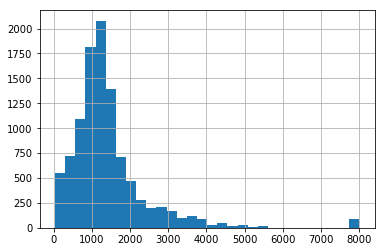

In [10]:
rent.hist(bins=30)

In [11]:
non_const_columns = data.var(axis=0) > 0

In [13]:
data_ = data[data.columns[non_const_columns]]

In [14]:
data_.shape

(10229, 174)

In [23]:
from sklearn.model_selection import train_test_split
data_train, data_test, rent_train, rent_test = train_test_split(data_, rent, random_state=1)

In [28]:
counts = np.array([len(data_train[col].value_counts()) for col in data_train.columns])

In [30]:
data_train[data_train.columns[counts > 10]].head()

,uf43,sc51,sc52,sc110,sc111,sc112,sc113,uf48,uf12,uf13,...,uf37,uf38,uf39a,uf40,cd,uf30,uf29,fw,chufw,seqno
346,46,3,2,99,11,11,11,12,9999,9999,...,9999999,9999999,999999,9999999,2,867,759,239.47278,99143898,255616
9064,24,6,1,1,7,7,7,12,9999,9999,...,9999999,9999999,999999,9999999,6,405,405,211.41603,41741961,74796
897,41,11,2,99,11,11,11,11,90,36,...,9999999,9999999,999999,9999999,5,1010,1010,225.35612,86950130,332736
4818,31,4,1,7,20,20,20,3,9999,9999,...,9999999,9999999,999999,9999999,13,103,103,179.96685,140526933,622803
5223,57,4,4,99,12,12,12,12,115,25,...,9999999,9999999,999999,9999999,14,274,243,172.53349,66491597,232986


In [33]:
raw_variables = pd.read_excel("../homeworks/homework2_variable_description.xls", skiprows=4)
# drop repeats of the header
raw_variables = raw_variables[raw_variables['Variable Name'] != "Variable Name"]

variables = raw_variables.dropna(subset=['Variable Name'])

# sometimes two variable names correspond to the same item
# the first variable starts with rec and they are in directly adjacent rows
for i, row in variables.iterrows():
    if i - 1 in variables.index:
        # the row above also has a variable name
        row_above = variables.loc[i-1]
        if row_above['Variable Name'].startswith("REC"):
            # this is one of the culprits
            #print(row)
            #print(row_above)
            # replace UF row with REC row
            variables.loc[i]['Item Name'] = variables.loc[i-1]['Item Name']

mask = variables['Item Name'].isnull()
variables = variables.copy()  # variables is a slice of a dataframe and not a dataframe before this.
variables['Item Name'][mask] = variables['Code and Description'][mask]
variables['Variable Name'] = variables['Variable Name'].str.strip(",").replace("SEX/HHR2", "HHR2")

variables = variables.set_index(variables['Variable Name'].str.lower())
variables.loc['uf43']['Item Name'] = variables.loc['hhr3t']['Item Name'] # manual fix ...
item_name = variables['Item Name']

source_codes = raw_variables.dropna(subset=['Source Code']).copy()
source_codes['Source Code'] = source_codes['Source Code'].astype("str").str.lstrip("0")
source_codes = source_codes.drop_duplicates(subset=["Source Code"])
sc_reindex = source_codes.set_index("sc" + source_codes['Source Code'])

source_code_series = sc_reindex['Item Name']

In [36]:
feature_mapping = {}
for c in data_.columns:
    if c in item_name.index:
        feature_mapping[c] = c + " " + item_name.loc[c]
    elif c in source_code_series.index:
        feature_mapping[c] = c + " " + source_code_series.loc[c]
    else:
        print(c)
feature_mapping['seqno'] = "seqno"

seqno


In [37]:
feature_mapping

{'boro': 'boro Borough',
 'cd': 'cd Sub-borough Area',
 'chufw': 'chufw Aggregate Persons Weight',
 'flg_ag1': "flg_ag1 Householder's age",
 'flg_hs1': 'flg_hs1 Householder of Spanish/Hispanic',
 'flg_rc1': "flg_rc1 Householder's  Race",
 'flg_sx1': "flg_sx1 Householder's sex",
 'fw': 'fw Household Weight',
 'hflag10': 'hflag10 Gas - Monthly Cost',
 'hflag11': 'hflag11 Water and Sewer - Yearly Cost',
 'hflag12': 'hflag12 Other Fuels - Yearly Cost',
 'hflag14': 'hflag14 Complete Plumbing Facilities',
 'hflag16': 'hflag16 Kitchen Facilities',
 'hflag18': 'hflag18 Monthly Rent Paid by Government',
 'hflag2': 'hflag2 Year Moved In',
 'hflag3': 'hflag3 Number of Rooms/Bedrooms',
 'hflag4': 'hflag4 Monthly Contract Rent',
 'hflag6': 'hflag6 Stories in Building',
 'hflag7': 'hflag7 Type of Heating Fuel',
 'hflag9': 'hflag9 Electricity - Monthly Cost',
 'hflag91': 'hflag91 Combined Gas/Electricity - Monthly Cost',
 'hhr2': "hhr2 Householder's Sex",
 'hhr5': 'hhr5 Origin',
 'new_csr': 'new_csr 

In [40]:
data_desc = data_.rename_axis(feature_mapping, axis=1)
data_train, data_test, rent_train, rent_test = train_test_split(data_desc, rent, random_state=1)

In [47]:
pd.Series(counts, index=data_desc.columns).sort_values(ascending=False)[:40]

seqno                                        7671
chufw Aggregate Persons Weight               5267
uf42 Total Household Income Recode           2432
fw Household Weight                          2232
uf26 Monthly Gross Rent                      1875
uf17a Out of Pocket Rent                     1326
uf28 Monthly Gross Rent per Room             1299
uf34 Household Income from Wages,            1008
uf27 Monthly Contract Rent Per                943
uf30 Monthly Gross Rent as Percent of         920
uf29 Monthly Contract Rent as                 897
uf37 Household Income from Social             537
uf38 Household Income from                    277
uf40 Household Income from                    182
uf39a Income Flag                             181
uf12 Monthly Cost                             173
uf35 Household Income from                    152
uf14 Combined Gas/Electricity                 145
uf13 Monthly Cost                             115
uf36 Household Income from Interest,          111


In [65]:
drop_continuous_etc = counts >= 20

data_discrete = data_desc.drop(data_desc.columns[drop_continuous_etc], axis=1)
data_train, data_test, rent_train, rent_test = train_test_split(data_discrete, rent, random_state=1)

In [66]:
data_desc.shape

(10229, 174)

In [67]:
data_discrete.shape

(10229, 142)

In [77]:
from sklearn.preprocessing import Imputer
X_train = Imputer(strategy="most_frequent").fit_transform(data_train)

In [78]:
X_train.shape

(7671, 142)

In [79]:
from sklearn.feature_selection import f_regression
F, p = f_regression(X_train, rent_train)

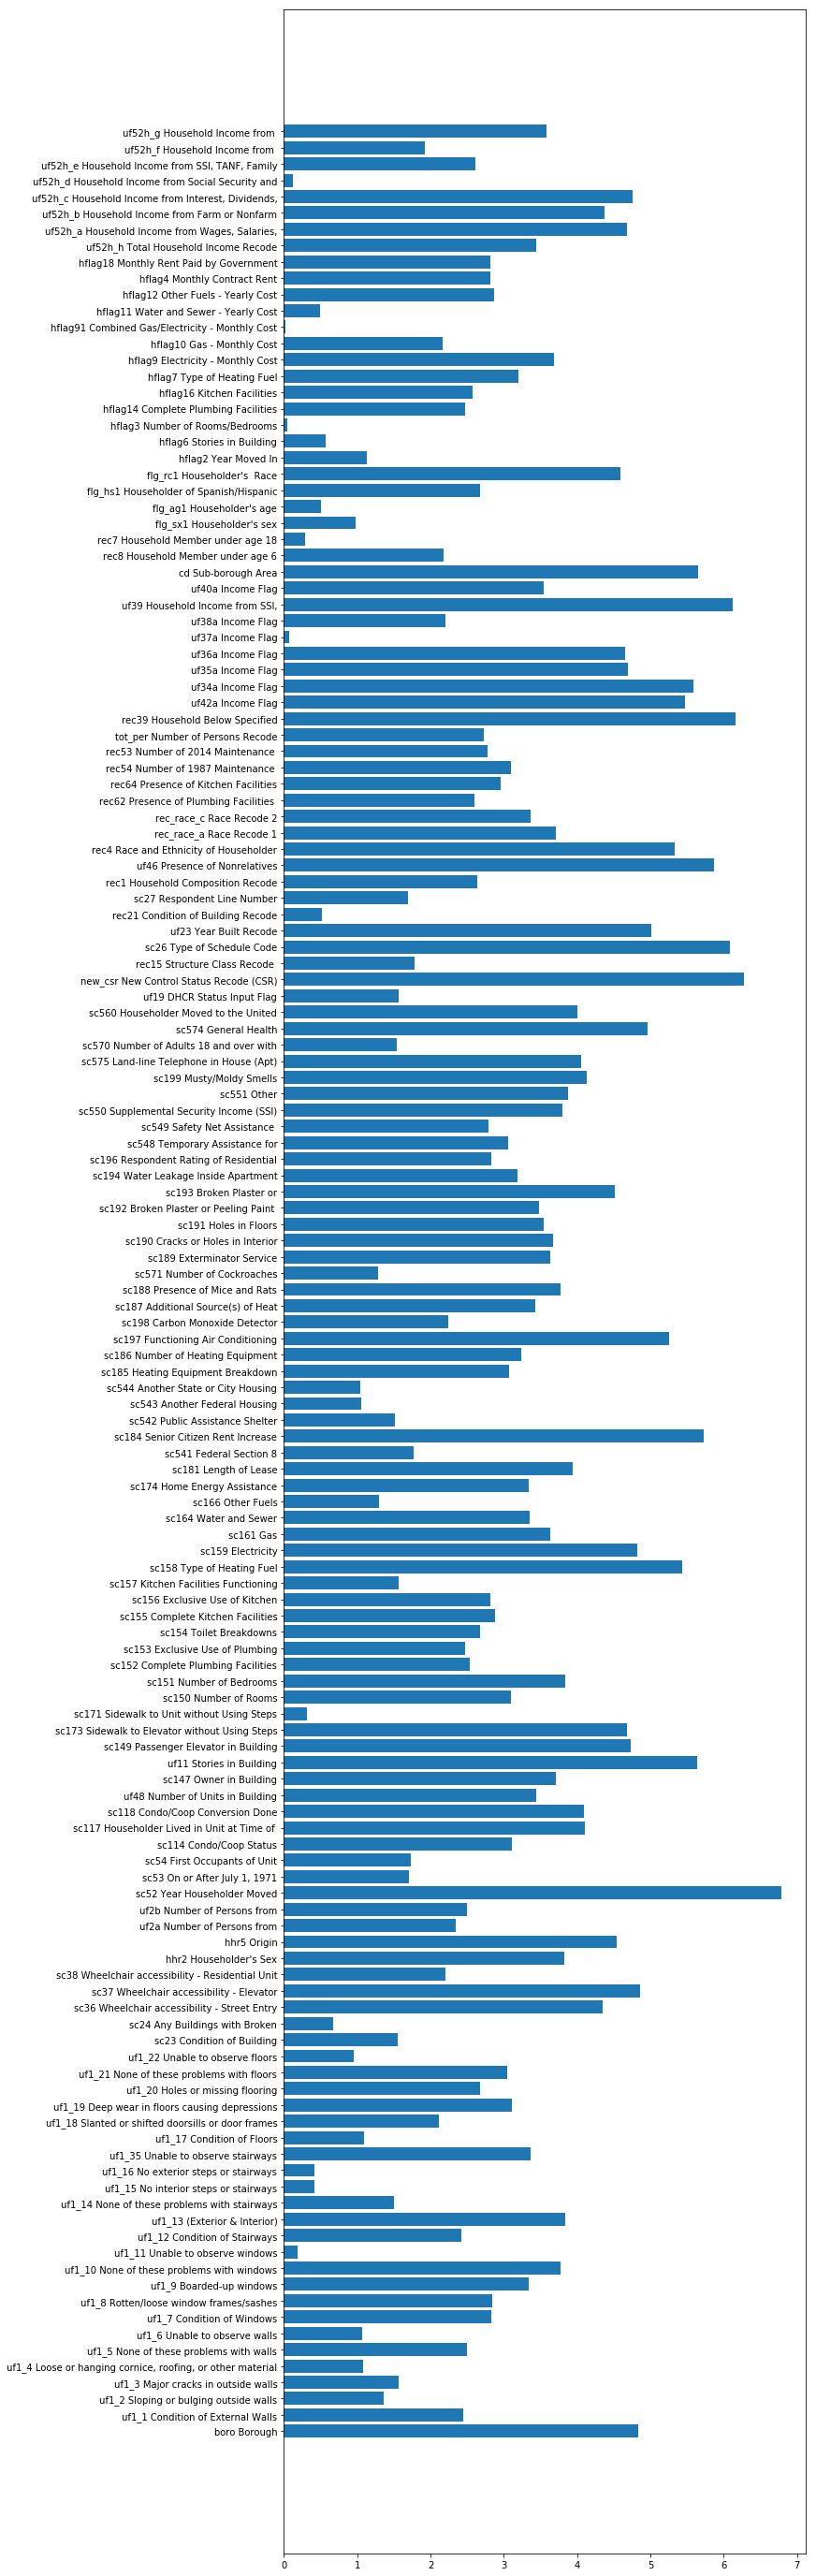

In [81]:
plt.figure(figsize=(10, 50))
plt.barh(np.arange(len(F)), np.log(F + 1))
plt.yticks(np.arange(len(F)), data_discrete.columns);

In [126]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X, rent.values)
inds = np.argsort(mi)


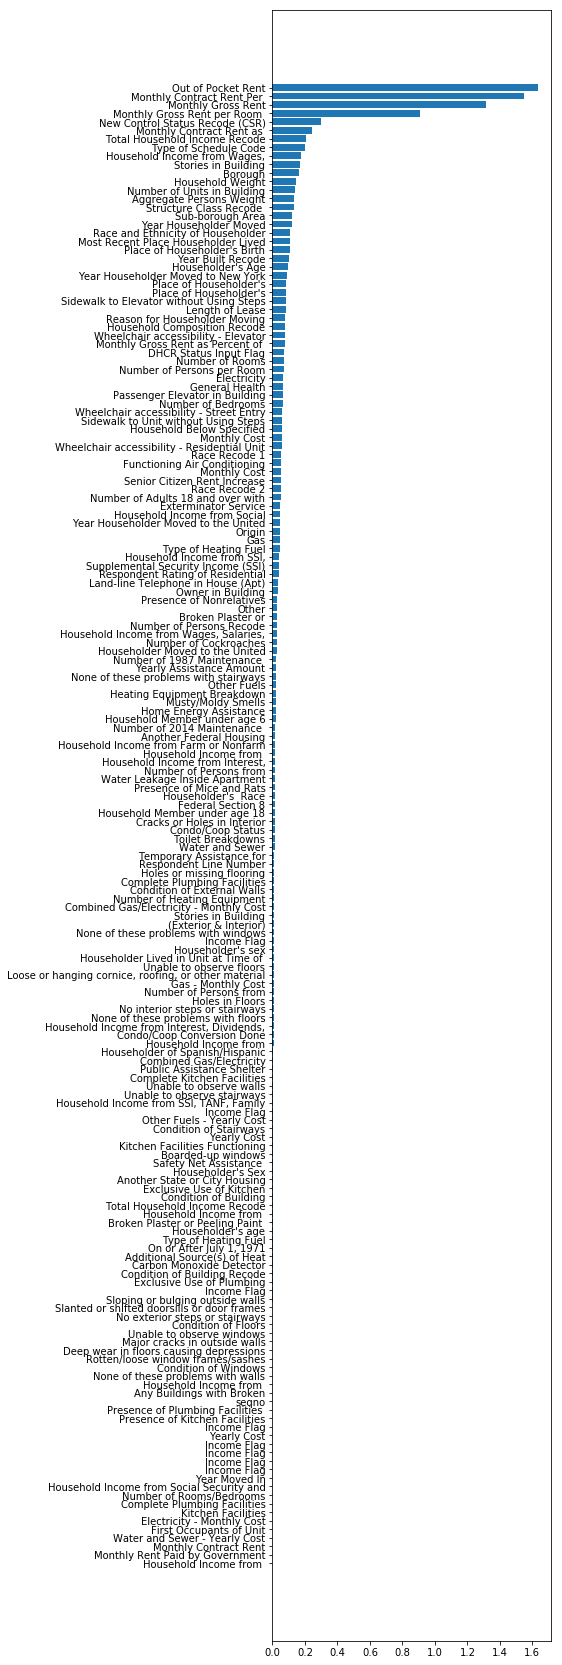

In [36]:
plt.figure(figsize=(5, 30))
plt.barh(np.arange(len(mi)), np.log(mi[inds] + 1))
plt.yticks(np.arange(len(mi)), map(lambda x: feature_mapping[x], data_.columns[inds]));

In [31]:
np.where(data_desc.columns == "Kitchen Facilities Functioning")

(array([58]),)

In [39]:
non_renter_columns = data_.columns[:58 + 1]
non_renter_columns = [i for i in non_renter_columns if "Householder" not in feature_mapping[i] and "Number of Persons from" not in feature_mapping[i] and "Origin" not in feature_mapping[i]]
non_renter_columns += ["new_csr"]

In [40]:
data_nr = data_[non_renter_columns]

In [41]:
X = Imputer(strategy="median").fit_transform(data_nr.values)
F, p = f_regression(X, rent.values)

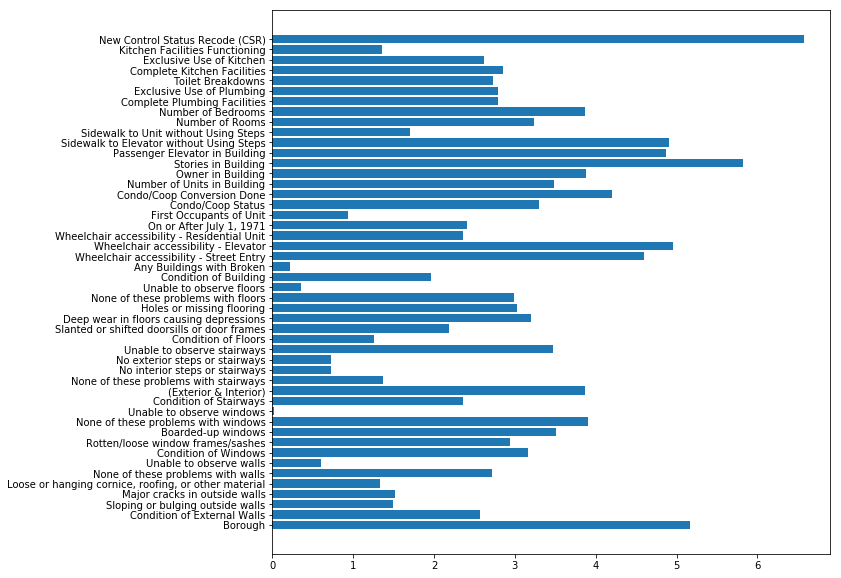

In [42]:
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(F)), np.log(F + 1))
plt.yticks(np.arange(len(F)), map(lambda x: feature_mapping[x], data_nr.columns));

In [43]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X, rent.values)

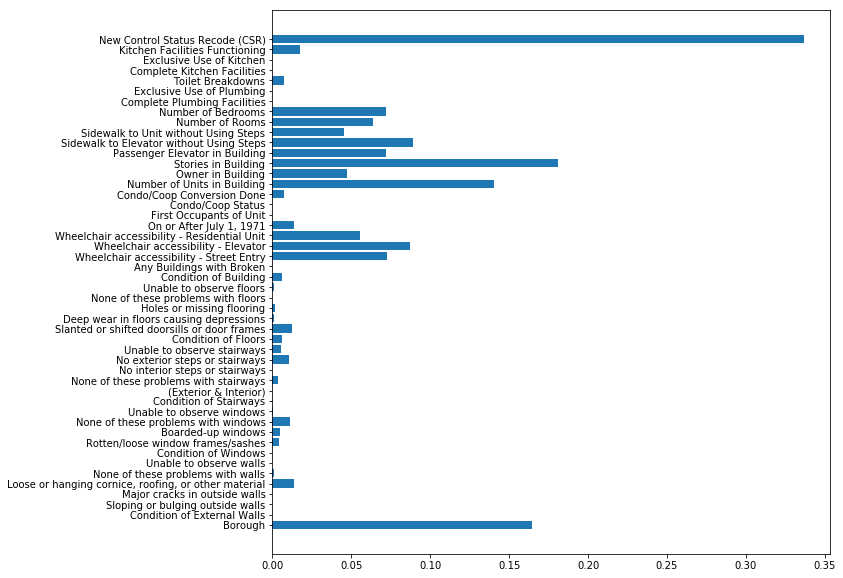

In [44]:
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(mi)), mi)
plt.yticks(np.arange(len(mi)), map(lambda x: feature_mapping[x], data_nr.columns));

In [127]:
from sklearn.feature_selection import SelectPercentile
select = SelectPercentile(mutual_info_regression, percentile=50)

In [128]:
select.fit(X, rent.values)

1 loop, best of 3: 13.9 s per loop


In [47]:
feature_names = [feature_mapping[x] for x in data_nr.columns[select.get_support()]]
feature_names

['Borough',
 'Sloping or bulging outside walls',
 'Loose or hanging cornice, roofing, or other material',
 'None of these problems with walls',
 'Condition of Stairways',
 '(Exterior & Interior)',
 'Condition of Floors',
 'None of these problems with floors',
 'Any Buildings with Broken',
 'Wheelchair accessibility - Street Entry',
 'Wheelchair accessibility - Elevator',
 'Wheelchair accessibility - Residential Unit',
 'Condo/Coop Status',
 'Condo/Coop Conversion Done',
 'Number of Units in Building',
 'Owner in Building',
 'Stories in Building',
 'Passenger Elevator in Building',
 'Sidewalk to Elevator without Using Steps',
 'Sidewalk to Unit without Using Steps',
 'Number of Rooms',
 'Number of Bedrooms',
 'Complete Kitchen Facilities',
 'New Control Status Recode (CSR)']

In [48]:
X_selected = select.transform(X)

In [49]:
len(feature_names)

24

In [50]:
y = rent.values

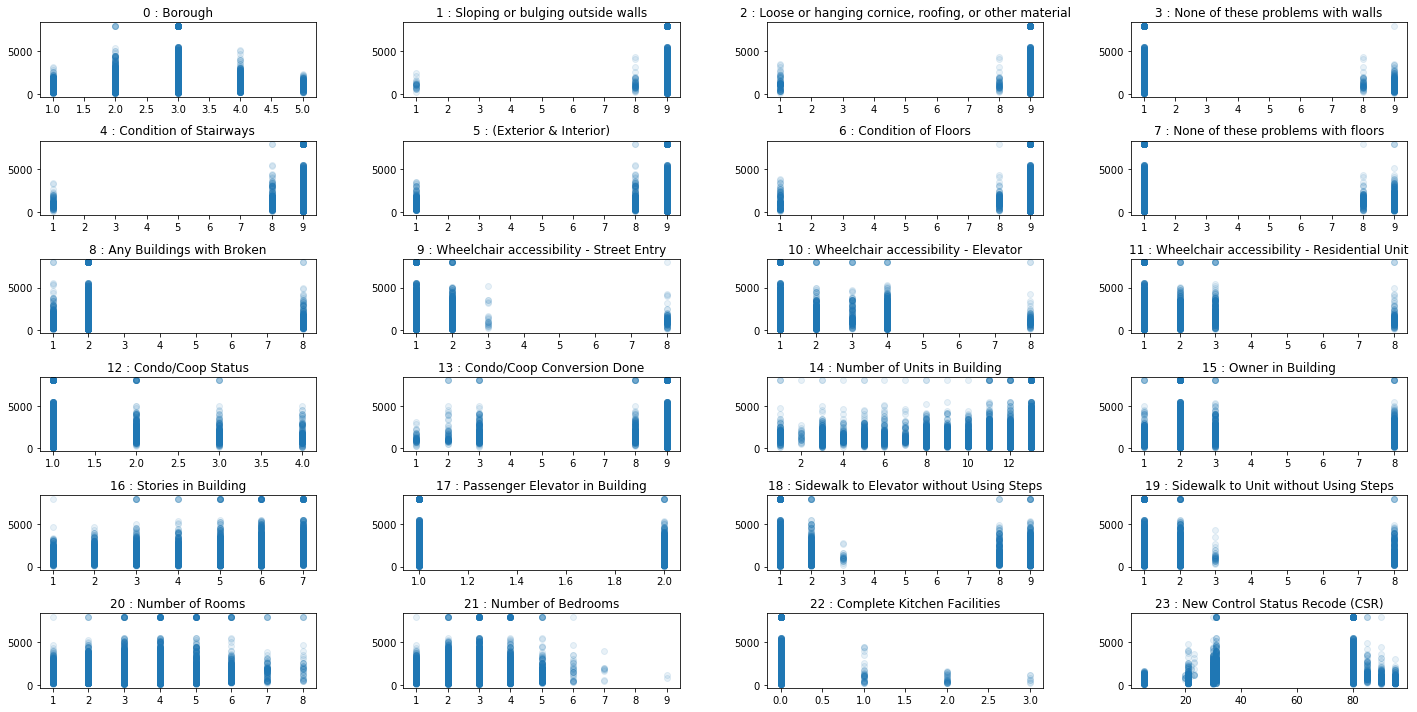

In [51]:
fig, axes = plt.subplots(6, 4, figsize=(20, 10))
for i, (name, ax) in enumerate(zip(feature_names, axes.ravel())):
    ax.scatter(X_selected[:, i], y, alpha=.1)
    ax.set_title("{} : {}".format(i, name))
plt.tight_layout()

In [52]:
X.shape

(10229, 48)

In [53]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected, y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)

In [54]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
rf.score(X_val, y_val)

0.48381168331671154

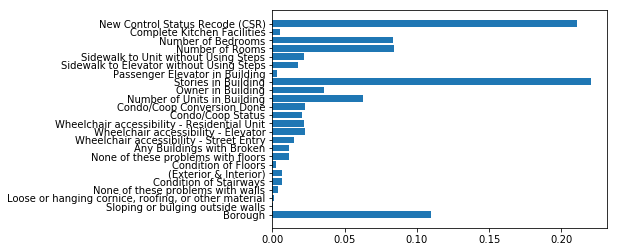

In [56]:
plt.barh(range(X_train.shape[1]), rf.feature_importances_)
plt.yticks(range(X_train.shape[1]), feature_names);

In [57]:
from sklearn.linear_model import LinearRegression
LinearRegression().fit(X_train, y_train).score(X_val, y_val)

0.19175056348682673

In [58]:
lr = LinearRegression().fit(X_train, y_train)
lr.score(X_val, y_val)

0.19175056348682673

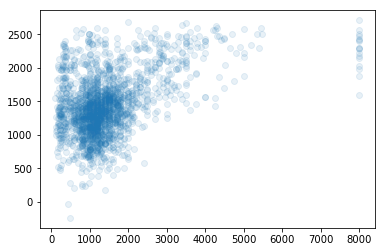

In [59]:
plt.scatter(y_val, lr.predict(X_val), alpha=.1)

In [60]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder().fit(X_train)

In [61]:
from sklearn.pipeline import make_pipeline
ohe_pipe = make_pipeline(OneHotEncoder(), LinearRegression())
ohe_pipe.fit(X_train, y_train).score(X_val, y_val)

0.48707157410770474

In [62]:
feature_names

['Borough',
 'Sloping or bulging outside walls',
 'Loose or hanging cornice, roofing, or other material',
 'None of these problems with walls',
 'Condition of Stairways',
 '(Exterior & Interior)',
 'Condition of Floors',
 'None of these problems with floors',
 'Any Buildings with Broken',
 'Wheelchair accessibility - Street Entry',
 'Wheelchair accessibility - Elevator',
 'Wheelchair accessibility - Residential Unit',
 'Condo/Coop Status',
 'Condo/Coop Conversion Done',
 'Number of Units in Building',
 'Owner in Building',
 'Stories in Building',
 'Passenger Elevator in Building',
 'Sidewalk to Elevator without Using Steps',
 'Sidewalk to Unit without Using Steps',
 'Number of Rooms',
 'Number of Bedrooms',
 'Complete Kitchen Facilities',
 'New Control Status Recode (CSR)']

In [63]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV, LassoLarsCV, Lars, Ridge, LassoLars
from sklearn.feature_selection import VarianceThreshold

ohe_interactions_pipe = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                                      RidgeCV())
ohe_interactions_pipe.fit(X_train, y_train).score(X_val, y_val)

0.53121451344346471

In [57]:
# converting the interactions to a sparse matrix is slightly faster
# - or not!
# ohe_interactions_pipe = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(),
#                                      FunctionTransformer(lambda X: sp.csr_matrix(X)), RidgeCV())
#ohe_interactions_pipe.fit(X_train, y_train).score(X_val, y_val)

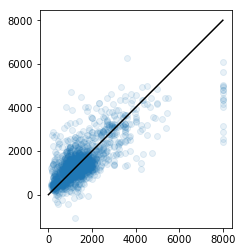

In [64]:
plt.scatter(y_val, ohe_interactions_pipe.predict(X_val), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, 8000], [0, 8000], c='k')

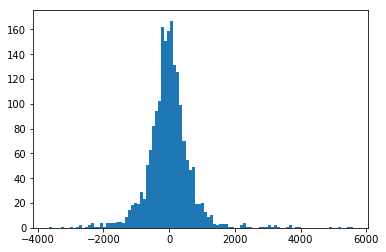

In [65]:
plt.hist(y_val - ohe_interactions_pipe.predict(X_val), bins=100);

In [66]:
from sklearn.feature_selection import VarianceThreshold
ohe_interactions_trans = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(include_bias=False, interaction_only=True), VarianceThreshold())
X_expanded = ohe_interactions_trans.fit_transform(X_train)

In [67]:
X_expanded.shape

(5753, 5496)

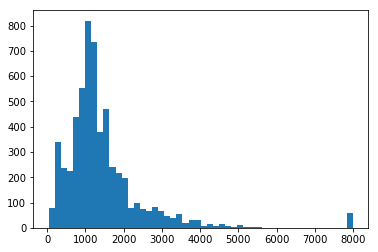

In [68]:
plt.hist(y_train, bins=50);

In [69]:
y_train.max()

7999.0

In [70]:
np.sum(y_train == y_train.max()) / len(y_train)

0.01025551885972536

In [71]:
y[y > 7000]

array([ 7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.])

In [72]:
# Drop 7999 as we can't learn anything from that
X_selected_ = X_selected[y<7999]
y_ = y[y<7999]
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected_, y_, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)

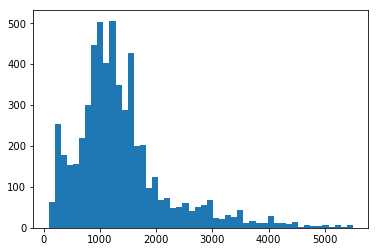

In [73]:
plt.hist(y_train, bins=50);

In [74]:
ohe_interactions_pipe = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                                      RidgeCV())
ohe_interactions_pipe.fit(X_train, y_train).score(X_val, y_val)

0.4963463541647703

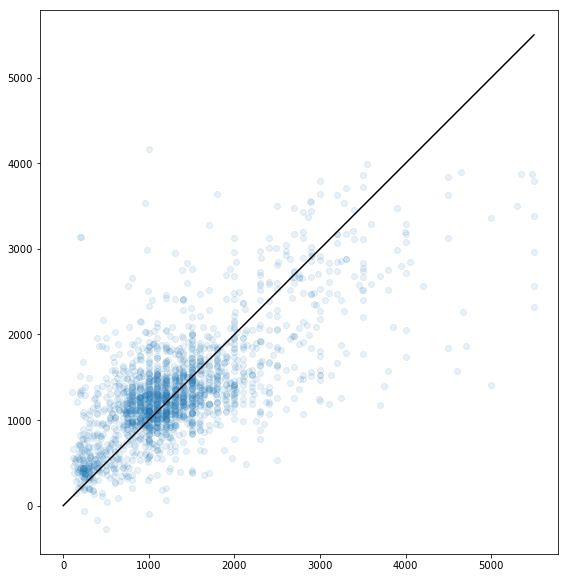

In [75]:
plt.figure(figsize=(10, 10))
plt.scatter(y_val, ohe_interactions_pipe.predict(X_val), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, y_val.max()], [0, y_val.max()], c='k')

In [76]:
from scipy.stats import boxcox

In [77]:
y_train_bc, l = boxcox(y_train)

In [78]:
l

0.27085608209529133

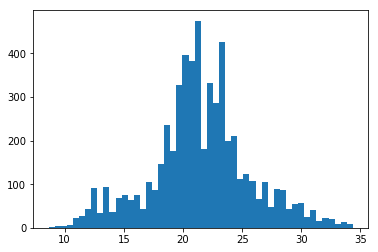

In [79]:
plt.hist(y_train_bc, bins=50);

In [80]:
1 / l

3.6919975813878332

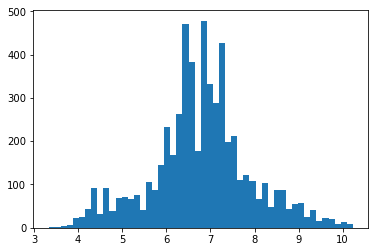

In [81]:
plt.hist(y_train ** .27, bins=50);

In [82]:
ohe_interactions_pipe = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                                      RidgeCV())
ohe_interactions_pipe.fit(X_train, y_train ** .27).score(X_val, y_val ** .27)

0.50961134641247385

In [83]:
from sklearn.metrics import r2_score
r2_score(y_val, ohe_interactions_pipe.predict(X_val) ** (1/.27))

0.48752395158721062

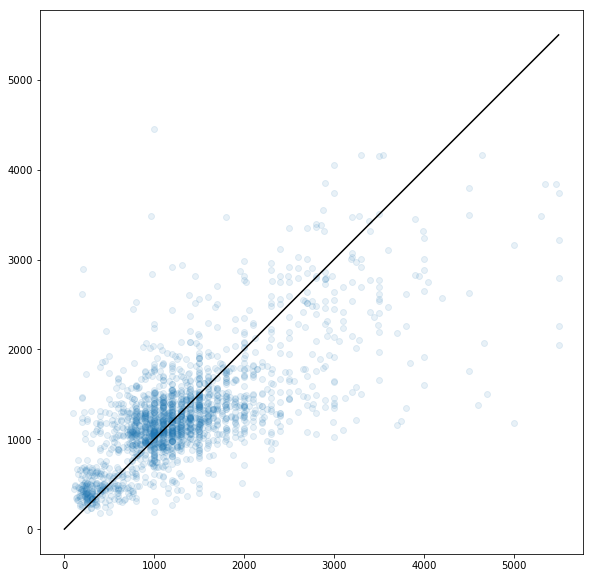

In [84]:
plt.figure(figsize=(10, 10))
plt.scatter(y_val, ohe_interactions_pipe.predict(X_val)** (1/.27), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, y_val.max()], [0, y_val.max()], c='k')

In [85]:
grr = pd.DataFrame(X_selected_.astype(np.int), columns=data_nr.columns[select.get_support()])
df_dummies = pd.get_dummies(grr, columns=grr.columns, prefix_sep="$")

In [86]:
X_dummies_ = df_dummies.values
X_trainval, X_test, y_trainval, y_test = train_test_split(X_dummies_, y_, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)

In [87]:
alphas = np.logspace(-3, 2, 11)
alphas

array([  1.00000000e-03,   3.16227766e-03,   1.00000000e-02,
         3.16227766e-02,   1.00000000e-01,   3.16227766e-01,
         1.00000000e+00,   3.16227766e+00,   1.00000000e+01,
         3.16227766e+01,   1.00000000e+02])

In [88]:
ridge = RidgeCV(alphas=alphas, store_cv_values=True).fit(X_train, y_train)

In [89]:
ridge.score(X_val, y_val)

0.48945173330267927

In [90]:
ridge.alpha_

3.1622776601683795

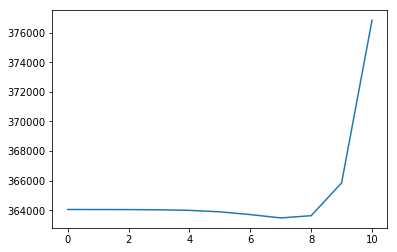

In [91]:
plt.plot(ridge.cv_values_.mean(axis=0))

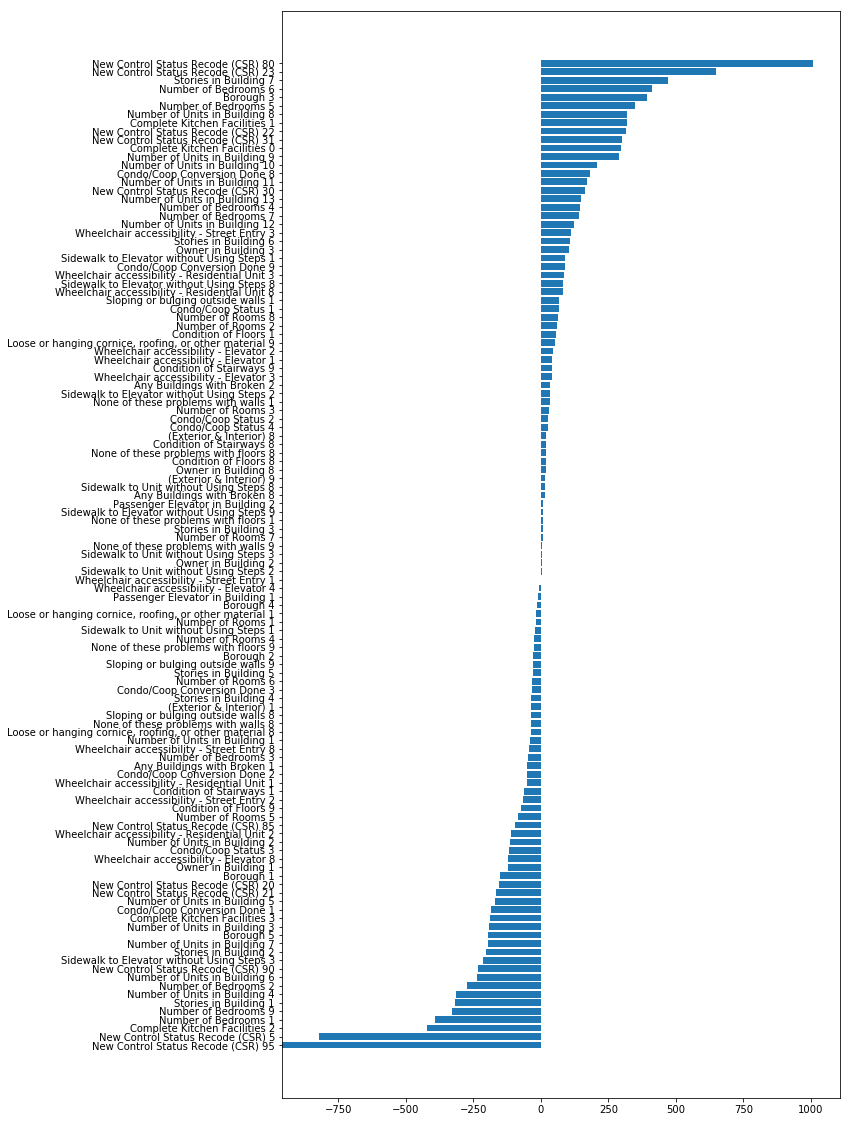

In [92]:
plt.figure(figsize=(10, 20))
inds = np.argsort(ridge.coef_)
plt.barh(range(len(inds)), ridge.coef_[inds])
plt.yticks(range(len(inds)), [feature_mapping[x.split("$")[0]] + " " + x.split("$")[1] for x in df_dummies.columns[inds]]);

In [99]:
ridge = RidgeCV().fit(X_train, y_train ** l)

In [100]:
r2_score(y_val, ridge.predict(X_val) ** (1/l))

0.49211321629020266

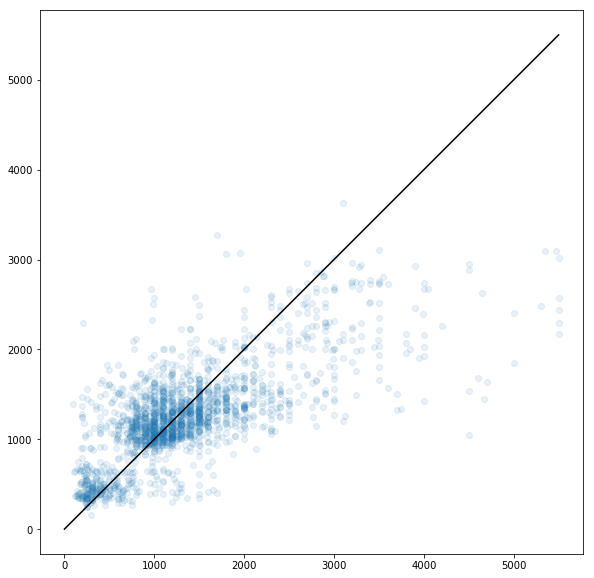

In [101]:
plt.figure(figsize=(10, 10))
plt.scatter(y_val, ridge.predict(X_val) ** (1/l), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, y_val.max()], [0, y_val.max()], c='k')

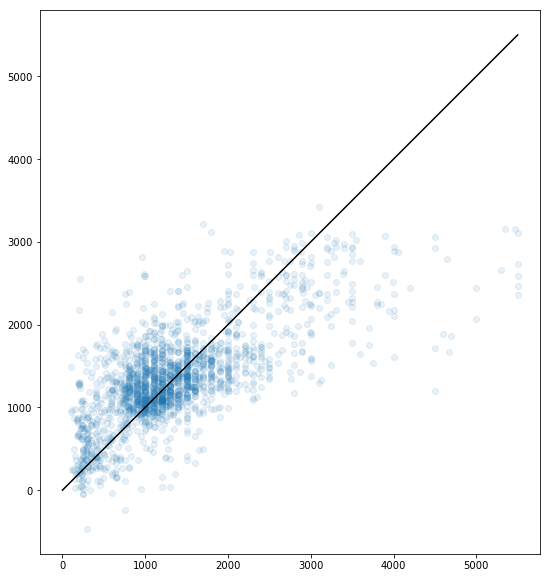

In [102]:
ridge = RidgeCV().fit(X_train, y_train)

plt.figure(figsize=(10, 10))
plt.scatter(y_val, ridge.predict(X_val), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, y_val.max()], [0, y_val.max()], c='k')

In [97]:
data_['new_csr'].value_counts()

80    3658
30    3533
31    1221
5      858
95     422
85     217
21     164
90     132
23      10
20      10
22       4
Name: new_csr, dtype: int64

In [104]:
df_dummies.columns

Index(['boro$1', 'boro$2', 'boro$3', 'boro$4', 'boro$5', 'uf1_2$1', 'uf1_2$8',
       'uf1_2$9', 'uf1_4$1', 'uf1_4$8',
       ...
       'new_csr$20', 'new_csr$21', 'new_csr$22', 'new_csr$23', 'new_csr$30',
       'new_csr$31', 'new_csr$80', 'new_csr$85', 'new_csr$90', 'new_csr$95'],
      dtype='object', length=117)

In [109]:
y_[(df_dummies['new_csr$80'] == 1).values]

array([ 1500.,   750.,  1650., ...,  1500.,   700.,   650.])

In [110]:
# only keep non-rent regulated
X_dummies_ = df_dummies[df_dummies['new_csr$80'] == 1].values
X_trainval, X_test, y_trainval, y_test = train_test_split(X_dummies_, y_[(df_dummies['new_csr$80'] == 1).values], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)

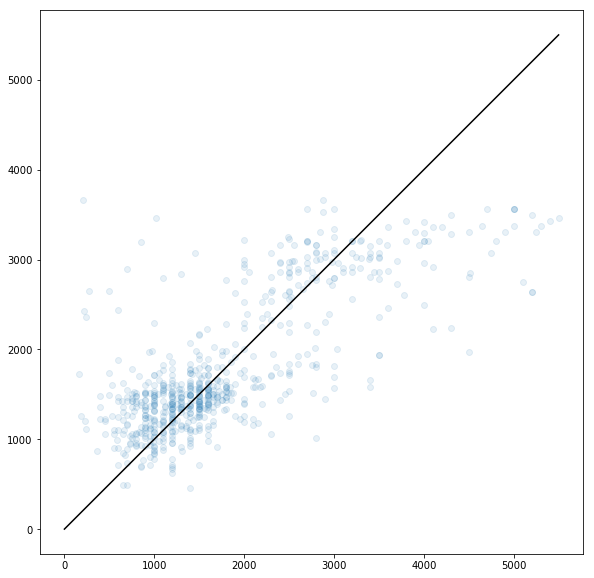

In [111]:
ridge = RidgeCV().fit(X_train, y_train)

plt.figure(figsize=(10, 10))
plt.scatter(y_val, ridge.predict(X_val), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, y_val.max()], [0, y_val.max()], c='k')

In [112]:
ridge.score(X_train, y_train)

0.59457443368995599

In [113]:
ridge.score(X_val, y_val)

0.58135937047531328

In [ ]:
ridge.coef_

In [ ]:
asdf = make

In [121]:
asdf = make_pipeline(PolynomialFeatures(interaction_only=True), VarianceThreshold(), RidgeCV(alphas=np.logspace(0, 4, 8)))
asdf.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('ridgecv', RidgeCV(alphas=array([  1.00000e+00,   3.72759e+00,   1.38950e+01,   5.17947e+01,
         1.93070e+02,   7.19686e+02,   2.68270e+03,   1.00000e+04]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False))])

In [122]:
asdf.named_steps['ridgecv'].alpha_

193.06977288832496

In [123]:
asdf.score(X_train, y_train)

0.66216874235517531

In [124]:
asdf.score(X_val, y_val)

0.58103571982054314

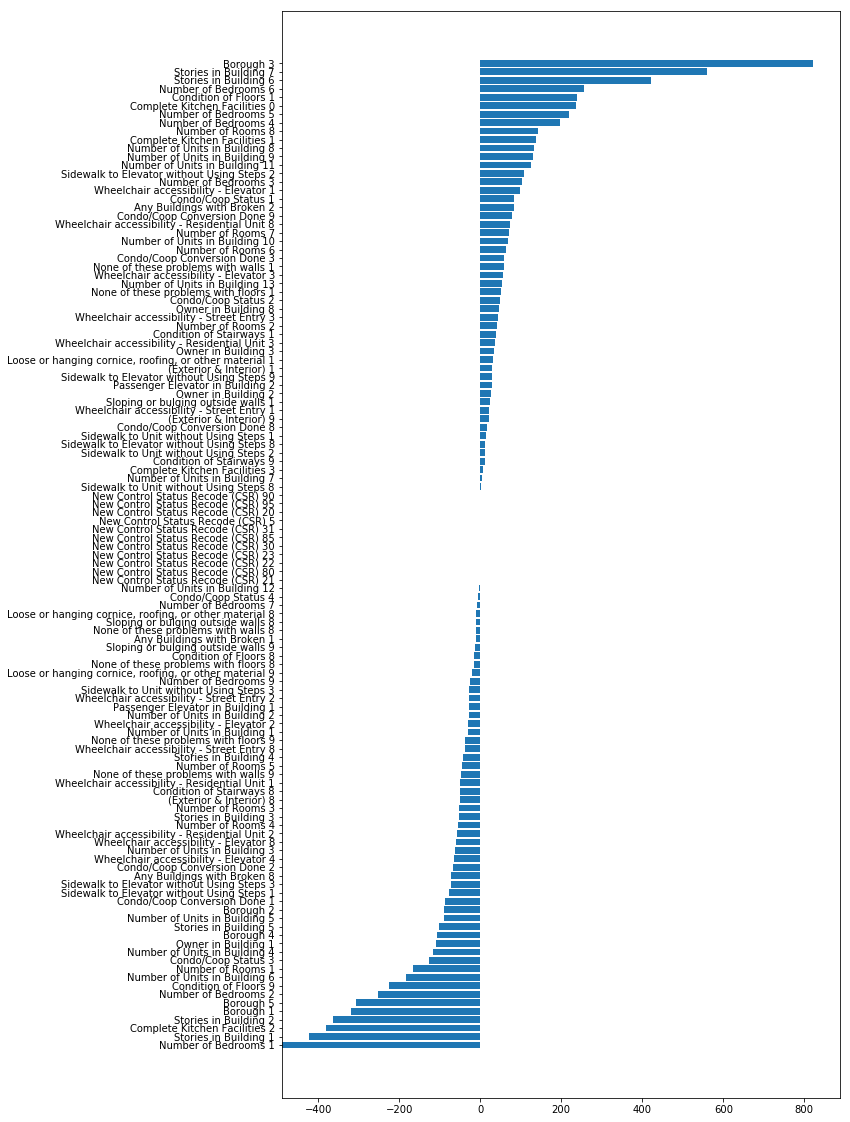

In [125]:
plt.figure(figsize=(10, 20))
inds = np.argsort(ridge.coef_)
plt.barh(range(len(inds)), ridge.coef_[inds])
plt.yticks(range(len(inds)), [feature_mapping[x.split("$")[0]] + " " + x.split("$")[1] for x in df_dummies.columns[inds]]);